# Traitement batch et ETL

Dans un premier temps, on charge les données à partir du hdfs, puis on effectuera une exploration pour vérifier la qualité des données, ensuite on procedera à un nettoyage des données.

In [7]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [16]:
#imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, count, mean, stddev, regexp_extract, avg, round, sum as _sum, floor,size,split,to_date
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
#initialisation de la session spark
spark = SparkSession.builder \
    .appName("BatchETLPipelineEnhanced") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

## 1- Exploration des données "Movie"

In [18]:
#chargement du csv movies
movies = spark.read.csv(
    "hdfs://namenode:9000/movie-lens/rawdata/movie.csv",
    header=True, inferSchema=True
)

In [5]:
# 1. Afficher le schéma du DataFrame
movies.printSchema()

# 2. Afficher les 5 premières lignes
movies.show(5, truncate=False)

# 3. Nombre de colonnes et de lignes
num_cols = len(movies.columns)
num_rows = movies.count()
print(f"Nombre de colonnes : {num_cols}")
print(f"Nombre de lignes : {num_rows}")

# 4. Résumé statistique
movies.describe().show()

# 5. Colonnes avec valeurs nulles
from pyspark.sql.functions import col, sum as _sum

null_counts = movies.select([_sum(col(c).isNull().cast("int")).alias(c) for c in movies.columns])
null_counts.show()

# 6. Distribution des films par année

movies = movies.withColumn("year", regexp_extract("title", r"\((\d{4})\)", 1).cast("int"))
movies.select("title", "year").show(5)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

Nombre de colonnes : 3
Nombre de lignes : 27278


+-------+-----------------+--------------------+------------------+
|summary|          movieId|               title|            genres|
+-------+-----------------+--------------------+------------------+
|  count|            27278|               27278|             27278|
|   mean|59855.48057042305|                NULL|              NULL|
| stddev|44429.31469707313|                NULL|              NULL|
|    min|                1|""Great Performan...|(no genres listed)|
|    max|           131262|       貞子3D (2012)|           Western|
+-------+-----------------+--------------------+------------------+

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+

+--------------------+----+
|               title|year|
+--------------------+----+
|    Toy Story (1995)|1995|
|      Jumanji (1995)|1995|
|Grumpier Old Men ...|1995|
|Waiting to Exhale...|1995|
|Father of the Bri...|1995|
+--------------------+----+
only showing top 5 ro

     year  nb_films
0    1891         1
1    1893         1
2    1894         2
3    1895         2
4    1896         2
..    ...       ...
113  2011      1016
114  2012      1022
115  2013      1011
116  2014       740
117  2015       120

[118 rows x 2 columns]


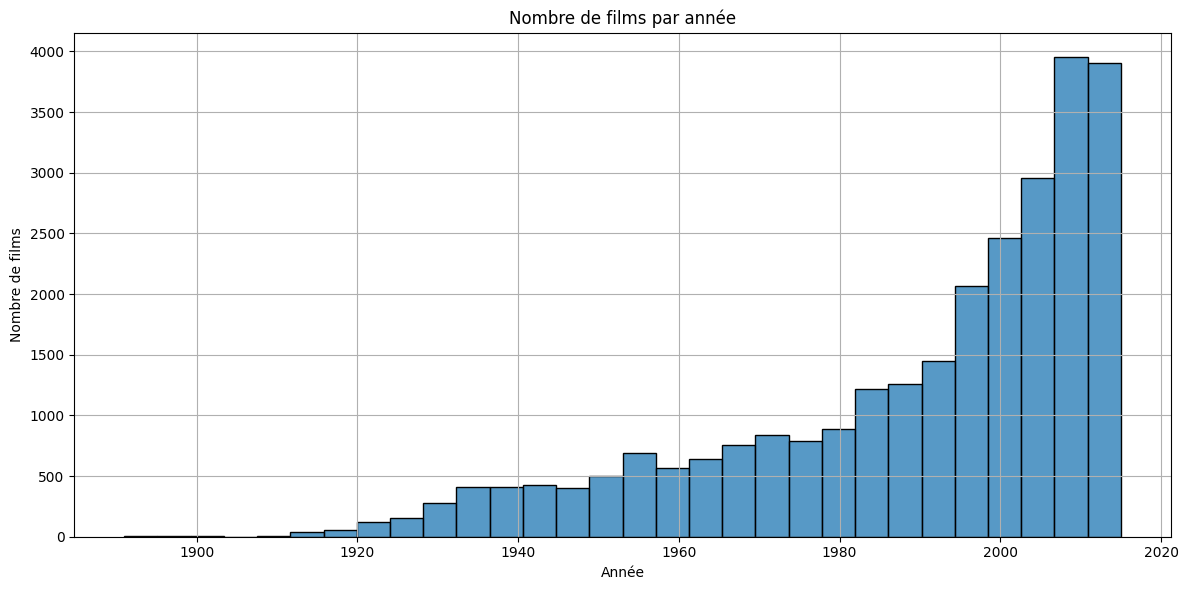

In [6]:
# Convertir en Pandas pour visualisation
movies_pd = movies.select("year").dropna().toPandas()

# Compter le nombre de films par année
films_par_annee = movies_pd.groupby("year").size().reset_index(name="nb_films")
films_par_annee = films_par_annee.sort_values("year")  # tri par année croissante

# Afficher le tableau
print(films_par_annee)

# 7. Visualisation : nombre de films par année
plt.figure(figsize=(12, 6))
sns.histplot(data=movies_pd, x="year", bins=30, kde=False)
plt.title("Nombre de films par année")
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.grid(True)
plt.tight_layout()
plt.show()

+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|13344|
|            Comedy| 8374|
|          Thriller| 4178|
|           Romance| 4127|
|            Action| 3520|
|             Crime| 2939|
|            Horror| 2611|
|       Documentary| 2471|
|         Adventure| 2329|
|            Sci-Fi| 1743|
|           Mystery| 1514|
|           Fantasy| 1412|
|               War| 1194|
|          Children| 1139|
|           Musical| 1036|
|         Animation| 1027|
|           Western|  676|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
+------------------+-----+



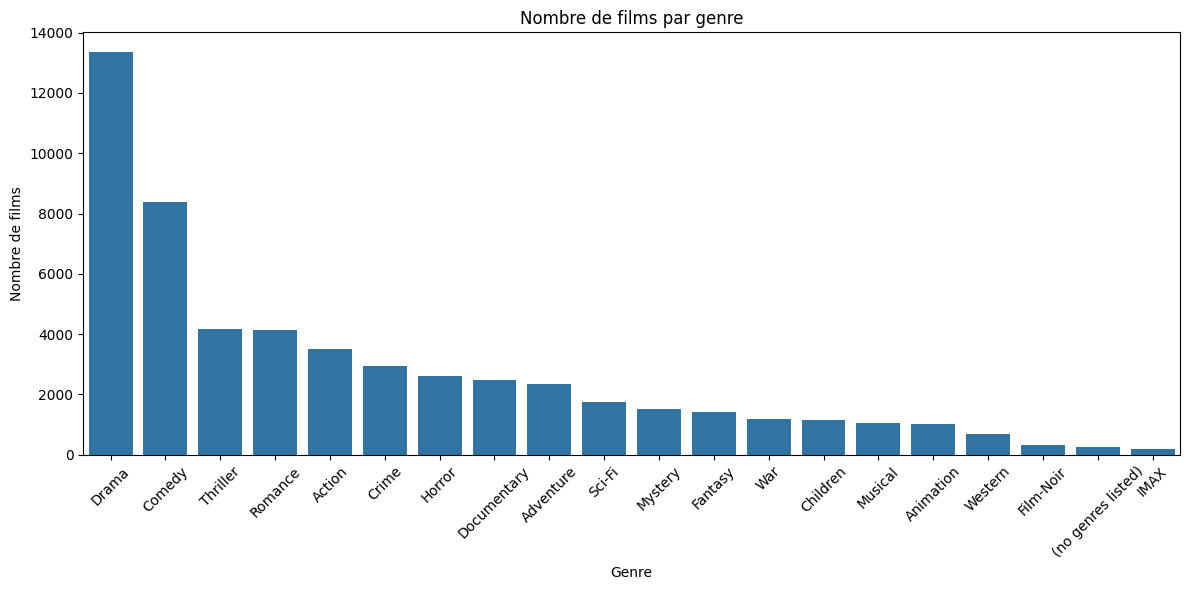

In [7]:
# 8. Genres les plus fréquents
if 'genres' in movies.columns:
    from pyspark.sql.functions import explode, split
    
    genre_counts = (
        movies
        .withColumn("genre", explode(split("genres", r"\|")))
        .groupBy("genre")
        .count()
        .orderBy("count", ascending=False)
    )
    genre_counts.show()

    # Visualisation
    genre_pd = genre_counts.toPandas()
    plt.figure(figsize=(12, 6))
    sns.barplot(x="genre", y="count", data=genre_pd)
    plt.xticks(rotation=45)
    plt.title("Nombre de films par genre")
    plt.xlabel("Genre")
    plt.ylabel("Nombre de films")
    plt.tight_layout()
    plt.show()

Pour le dataset movie, il n'y a pas de valeur manquante, il n'y a pas de nettoyage nécessaire, le genre "Drama" est le plus représenté dans le dataset et que c'est durant les deux dernières décennies que le plus de films sont sortis.

## 2- Exploration des données "Rating"

In [19]:
#chargement du csv rating
ratings = spark.read.csv(
    "hdfs://namenode:9000/movie-lens/rawdata/rating.csv",
    header=True, inferSchema=True
)

In [12]:
# 1. Afficher le schéma du DataFrame
ratings.printSchema()

# 2. Afficher les 5 premières lignes
ratings.show(5, truncate=False)

# 3. Nombre de colonnes et de lignes
num_cols = len(ratings.columns)
num_rows = ratings.count()
print(f"Nombre de colonnes : {num_cols}")
print(f"Nombre de lignes : {num_rows}")

# 4. Résumé statistique
ratings.describe().show()

# 5. Colonnes avec valeurs nulles
null_counts = ratings.select([_sum(col(c).isNull().cast("int")).alias(c) for c in ratings.columns])
null_counts.show()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)

+------+-------+------+-------------------+
|userId|movieId|rating|timestamp          |
+------+-------+------+-------------------+
|1     |2      |3.5   |2005-04-02 23:53:47|
|1     |29     |3.5   |2005-04-02 23:31:16|
|1     |32     |3.5   |2005-04-02 23:33:39|
|1     |47     |3.5   |2005-04-02 23:32:07|
|1     |50     |3.5   |2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



Nombre de colonnes : 4
Nombre de lignes : 20000263


+-------+-----------------+------------------+------------------+
|summary|           userId|           movieId|            rating|
+-------+-----------------+------------------+------------------+
|  count|         20000263|          20000263|          20000263|
|   mean|69045.87258292554| 9041.567330339605|3.5255285642993797|
| stddev|40038.62665316145|19789.477445413166|1.0519889192942444|
|    min|                1|                 1|               0.5|
|    max|           138493|            131262|               5.0|
+-------+-----------------+------------------+------------------+



[Stage 44:==================================================>       (7 + 1) / 8]

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



In [46]:
nb_films1 = movies.select("movieId").distinct().count()
print(f"Nombre total de films dataset Movies: {nb_films1}")


Nombre total de films dataset Movies: 27278


In [48]:
nb_films = ratings.select("movieId").distinct().count()
print(f"Nombre total de films notés (dataset Rating): {nb_films}")


Nombre total de films notés (dataset Rating): 26744


In [15]:
#Top 10 des films les plus notés avec les titres et les genres
ratings_with_titles = ratings.join(movies, on="movieId", how="inner")

# Compter le nombre de notes par film
films_plus_notes = ratings_with_titles.groupBy("movieId", "title", "genres") \
                                      .agg(count("*").alias("nb_notes")) \
                                      .orderBy("nb_notes", ascending=False)

films_plus_notes.show(10, truncate=False)


[Stage 51:==================================================>       (7 + 1) / 8]

+-------+-----------------------------------------+--------------------------------+--------+
|movieId|title                                    |genres                          |nb_notes|
+-------+-----------------------------------------+--------------------------------+--------+
|296    |Pulp Fiction (1994)                      |Comedy|Crime|Drama|Thriller     |67310   |
|356    |Forrest Gump (1994)                      |Comedy|Drama|Romance|War        |66172   |
|318    |Shawshank Redemption, The (1994)         |Crime|Drama                     |63366   |
|593    |Silence of the Lambs, The (1991)         |Crime|Horror|Thriller           |63299   |
|480    |Jurassic Park (1993)                     |Action|Adventure|Sci-Fi|Thriller|59715   |
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi         |54502   |
|110    |Braveheart (1995)                        |Action|Drama|War                |53769   |
|589    |Terminator 2: Judgment Day (1991)        |Action|Sc

In [53]:
# Joindre ratings avec movies pour avoir les titres
ratings_with_titles = ratings.join(movies, on="movieId", how="inner")

# Calculer nombre de notes et note moyenne par film
top_films = ratings_with_titles.groupBy("movieId", "title") \
    .agg(
        count("*").alias("nb_notes"),
        round(avg("rating"), 2).alias("note_moyenne")
    ) \
    .orderBy("nb_notes", ascending=False) \
    .limit(10)

# Afficher le top 10
top_films.show(truncate=False)


+-------+-----------------------------------------+--------+------------+
|movieId|title                                    |nb_notes|note_moyenne|
+-------+-----------------------------------------+--------+------------+
|296    |Pulp Fiction (1994)                      |67310   |4.17        |
|356    |Forrest Gump (1994)                      |66172   |4.03        |
|318    |Shawshank Redemption, The (1994)         |63366   |4.45        |
|593    |Silence of the Lambs, The (1991)         |63299   |4.18        |
|480    |Jurassic Park (1993)                     |59715   |3.66        |
|260    |Star Wars: Episode IV - A New Hope (1977)|54502   |4.19        |
|110    |Braveheart (1995)                        |53769   |4.04        |
|589    |Terminator 2: Judgment Day (1991)        |52244   |3.93        |
|2571   |Matrix, The (1999)                       |51334   |4.19        |
|527    |Schindler's List (1993)                  |50054   |4.31        |
+-------+-----------------------------

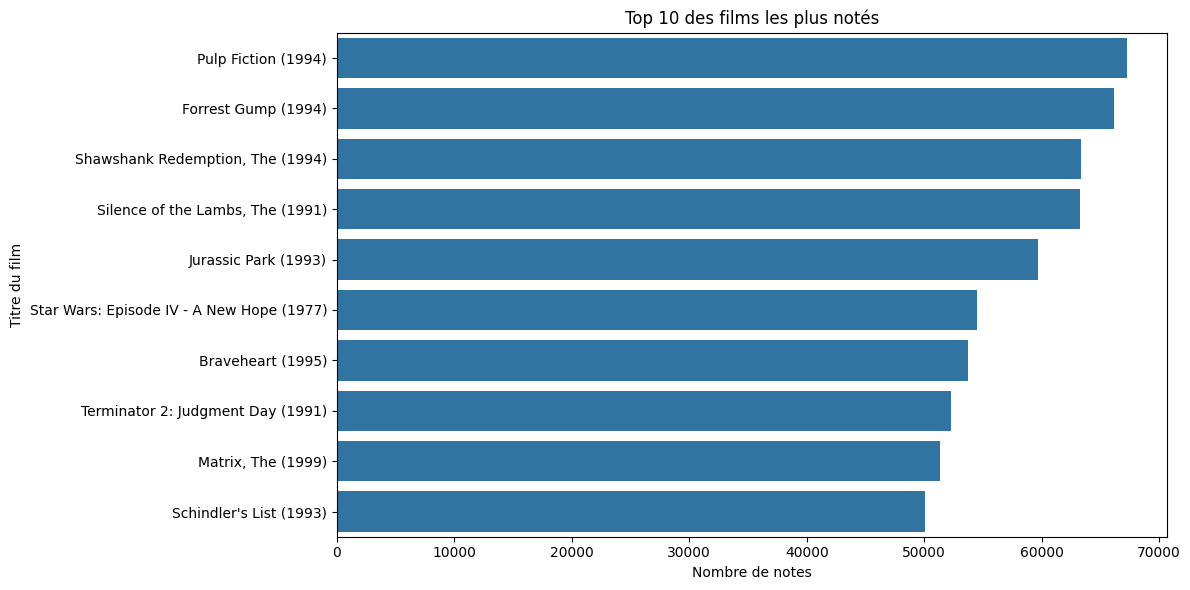

In [16]:
# Convertir en Pandas pour visualisation
films_plus_notes_pd = films_plus_notes.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=films_plus_notes_pd, x='nb_notes', y='title')
plt.title("Top 10 des films les plus notés")
plt.xlabel("Nombre de notes")
plt.ylabel("Titre du film")
plt.tight_layout()
plt.show()

In [49]:
# Moyenne des notes des TOP 10
films_plus_notes = ratings_with_titles.groupBy("movieId", "title", "genres") \
    .agg(
        count("*").alias("nb_notes"),
        avg("rating").alias("moyenne_notes")
    ) \
    .orderBy("nb_notes", ascending=False)

# Affichage du top 10
films_plus_notes.show(10, truncate=False)


+-------+-----------------------------------------+--------------------------------+--------+------------------+
|movieId|title                                    |genres                          |nb_notes|moyenne_notes     |
+-------+-----------------------------------------+--------------------------------+--------+------------------+
|296    |Pulp Fiction (1994)                      |Comedy|Crime|Drama|Thriller     |67310   |4.174231169217055 |
|356    |Forrest Gump (1994)                      |Comedy|Drama|Romance|War        |66172   |4.029000181345584 |
|318    |Shawshank Redemption, The (1994)         |Crime|Drama                     |63366   |4.446990499637029 |
|593    |Silence of the Lambs, The (1991)         |Crime|Horror|Thriller           |63299   |4.17705650958151  |
|480    |Jurassic Park (1993)                     |Action|Adventure|Sci-Fi|Thriller|59715   |3.6647408523821485|
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi         |54502   |4.1

/tmp/ipykernel_4115/223241266.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=top_films_pd, x="moyenne_note", y="title", palette="viridis")
/tmp/ipykernel_4115/223241266.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=top_films_pd, x="nb_notes", y="title", palette="mako")


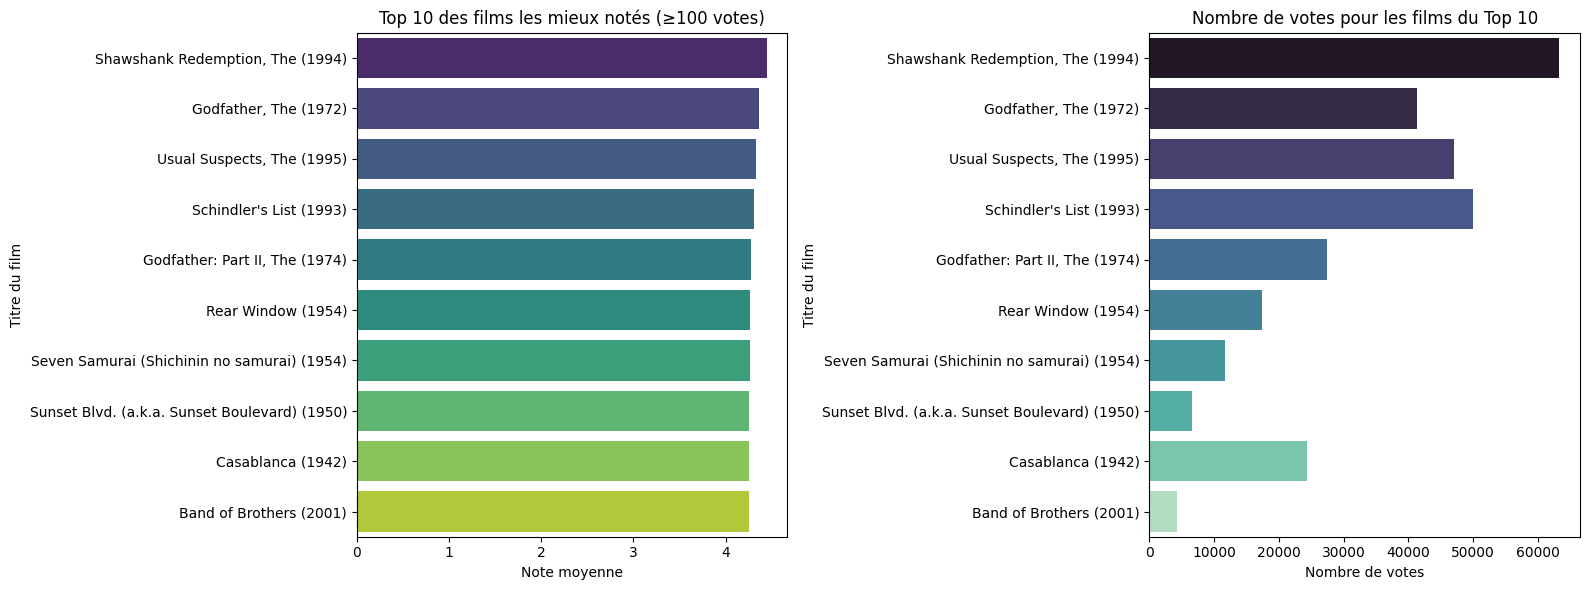

In [57]:
# Calcul des statistiques par film
stats_films = ratings_with_titles.groupBy("movieId", "title") \
    .agg(
        count("*").alias("nb_notes"),
        round(avg("rating"), 2).alias("moyenne_note")
    )

# Filtrer les films avec un nombre de notes >= 100
top_films_notes = stats_films.filter("nb_notes >= 100") \
    .orderBy("moyenne_note", ascending=False) \
    .limit(10)

# Convertir en Pandas pour visualisation
top_films_pd = top_films_notes.toPandas()

# Compter les occurrences de chaque note
etoiles_pd = ratings.groupBy("rating").count().orderBy("rating").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Top 10 des films les mieux notés
sns.barplot(ax=axes[0], data=top_films_pd, x="moyenne_note", y="title", palette="viridis")
axes[0].set_title("Top 10 des films les mieux notés (≥100 votes)")
axes[0].set_xlabel("Note moyenne")
axes[0].set_ylabel("Titre du film")

# Graphique 2 : Nombre de votes pour chaque film du Top 10
sns.barplot(ax=axes[1], data=top_films_pd, x="nb_notes", y="title", palette="mako")
axes[1].set_title("Nombre de votes pour les films du Top 10")
axes[1].set_xlabel("Nombre de votes")
axes[1].set_ylabel("Titre du film")

plt.tight_layout()
plt.show()

In [20]:
# Nombre de films ayant au moins une note de 0.5
films_05 = ratings.filter(col("rating") == 0.5).select("movieId").distinct().count()

# Nombre de films ayant au moins une note de 5.0
films_5 = ratings.filter(col("rating") == 5.0).select("movieId").distinct().count()

print(f"Nombre de films ayant reçu au moins une note de 0.5 : {films_05}")
print(f"Nombre de films ayant reçu au moins une note de 5.0 : {films_5}")


Nombre de films ayant reçu au moins une note de 0.5 : 13581
Nombre de films ayant reçu au moins une note de 5.0 : 14474


In [25]:
# Nombre total d’utilisateurs
nb_users = ratings.select("userId").distinct().count()
print(f"Nombre total d'utilisateurs : {nb_users}")


Nombre total d'utilisateurs : 138493


In [29]:
# Nombre de notes par utilisateur
notes_par_user = ratings.groupBy("userId").agg(count("rating").alias("nb_notes"))

# Par paliers de tranches de 100 notes
notes_par_user = notes_par_user.withColumn("palier", floor(col("nb_notes") / 100) * 100)

# Compter le nombre d'utilisateurs par palier
utilisateurs_par_palier = notes_par_user.groupBy("palier").count().orderBy("palier")
utilisateurs_par_palier.show()


+------+-----+
|palier|count|
+------+-----+
|     0|85897|
|   100|25770|
|   200|10519|
|   300| 5605|
|   400| 3211|
|   500| 2135|
|   600| 1355|
|   700|  957|
|   800|  690|
|   900|  460|
|  1000|  449|
|  1100|  302|
|  1200|  239|
|  1300|  177|
|  1400|  146|
|  1500|  107|
|  1600|   76|
|  1700|   61|
|  1800|   37|
|  1900|   45|
+------+-----+
only showing top 20 rows



In [28]:
#Par pallier de tranches de 50 notes
notes_par_user = ratings.groupBy("userId").agg(count("rating").alias("nb_notes"))

notes_par_user = notes_par_user.filter(col("nb_notes") <= 2000)
notes_par_user = notes_par_user.withColumn("palier", floor(col("nb_notes") / 20) * 20)

# Compter le nombre d'utilisateurs par palier
utilisateurs_par_palier = notes_par_user.groupBy("palier").count().orderBy("palier")
utilisateurs_par_palier.show()


25/04/29 14:20:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 14:20:21 WARN RowBasedKeyValueBatch: Calling spill() on

+------+-----+
|palier|count|
+------+-----+
|    20|41617|
|    40|21360|
|    60|13712|
|    80| 9208|
|   100| 8513|
|   120| 5908|
|   140| 4621|
|   160| 3800|
|   180| 2928|
|   200| 3024|
|   220| 2354|
|   240| 2030|
|   260| 1684|
|   280| 1427|
|   300| 1535|
|   320| 1225|
|   340| 1051|
|   360|  939|
|   380|  855|
|   400|  839|
+------+-----+
only showing top 20 rows



In [42]:
nb_films = ratings.select("movieId").distinct().count()
print(f"Nombre total de films : {nb_films}")


Nombre total de films : 26744


/tmp/ipykernel_4115/3367433292.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=palier_pd, x="palier", y="count", palette="crest")


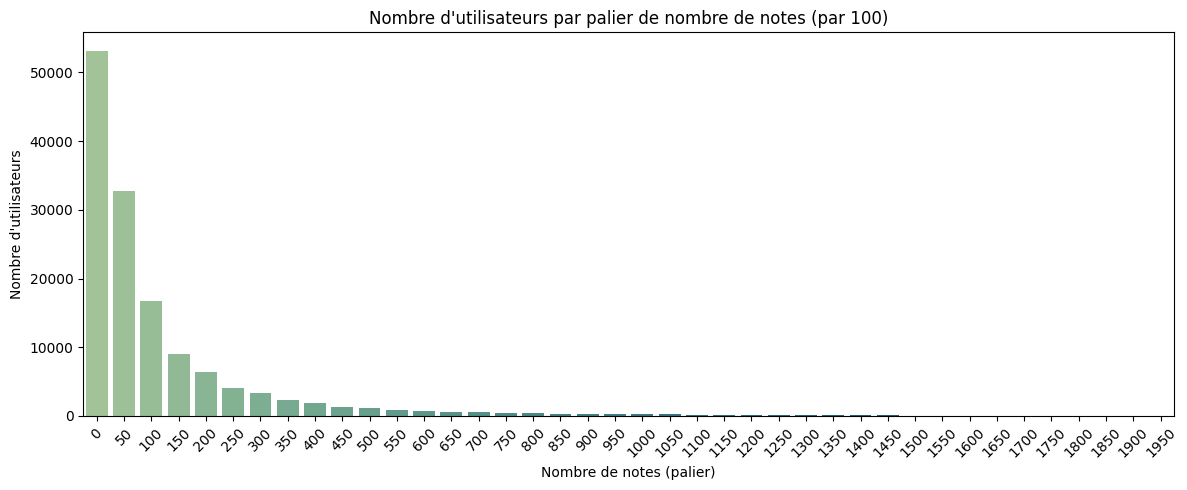

In [35]:
# Convertir pour affichage
palier_pd = utilisateurs_par_palier.toPandas()

plt.figure(figsize=(12, 5))
sns.barplot(data=palier_pd, x="palier", y="count", palette="crest")
plt.title("Nombre d'utilisateurs par palier de nombre de notes (par 100)")
plt.xlabel("Nombre de notes (palier)")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


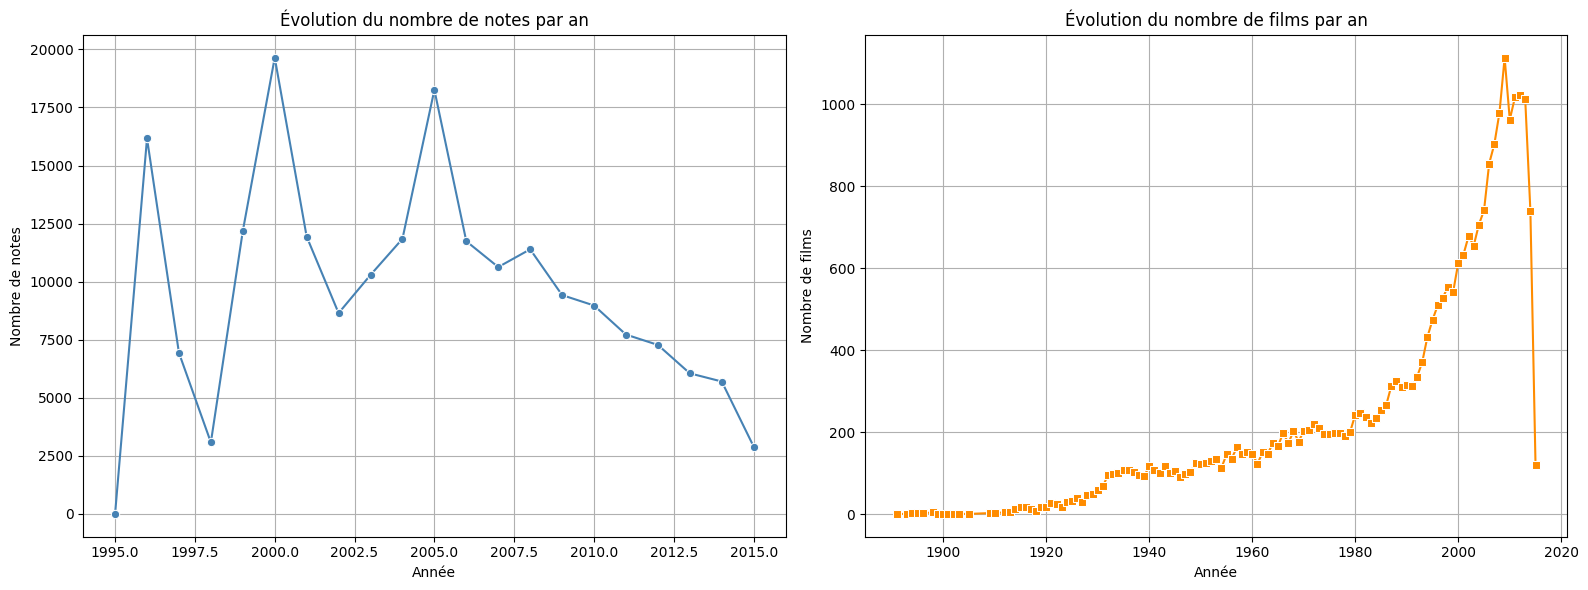

In [38]:
# Nombre de notes par année
notes_par_annee = ratings_pd.groupby('year').size().reset_index(name='nb_notes')

# Nombre de films par année
films_par_annee = movies_pd.groupby('year').size().reset_index(name='nb_films')
 
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# Graphique 1 : nombre de notes
sns.lineplot(ax=axes[0], data=notes_par_annee, x='year', y='nb_notes', marker='o', color='steelblue')
axes[0].set_title("Évolution du nombre de notes par an")
axes[0].set_xlabel("Année")
axes[0].set_ylabel("Nombre de notes")
axes[0].grid(True)

# Graphique 2 : nombre de films
sns.lineplot(ax=axes[1], data=films_par_annee, x='year', y='nb_films', marker='s', color='darkorange')
axes[1].set_title("Évolution du nombre de films par an")
axes[1].set_xlabel("Année")
axes[1].set_ylabel("Nombre de films")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Dans le dataset "Rating", la plus grande majorité des utilisateurs ont noté entre 0 et 50 films. D'après les différentes visualisations, l'année où les
notes sont les plus élevées n'est pas forcément celle avec le plus de films produits. 

### 

### 3 - Nettoyage des données


In [20]:
# Nettoyage initial des données
# Nettoyage des films
movies = movies.dropna()  # Supprimer les lignes avec des valeurs manquantes
movies = movies.dropDuplicates(['movieId'])  # Supprimer les doublons

# Nettoyage des évaluations
ratings = ratings.dropna()
ratings = ratings.dropDuplicates(['userId', 'movieId'])  # Une évaluation par utilisateur/film

In [21]:
# Extraction de l'année du titre du film
movies = movies.withColumn('year', year(regexp_extract('title', r'\((\d{4})\)', 1)))

# Calcul du nombre de genres pour chaque film
movies = movies.withColumn('genre_count', size(split('genres', '[|]')))

In [22]:
movies

DataFrame[movieId: int, title: string, genres: string, year: int, genre_count: int]

In [23]:
ratings = ratings.withColumn('rating_date', to_date('timestamp')).withColumn('rating_year', year('timestamp')).withColumn('rating_month', month('timestamp')).withColumn('rating_day', dayofmonth('timestamp'))

In [24]:
ratings

DataFrame[userId: int, movieId: int, rating: double, timestamp: timestamp, rating_date: date, rating_year: int, rating_month: int, rating_day: int]

In [25]:
# Filtrer les évaluations extrêmes (trop basses ou trop hautes)
ratings = ratings.filter((ratings.rating >= 0.5) & (ratings.rating <= 5.0))


In [26]:
#ne garder que les films avec un minimum d'évaluations
from pyspark.sql.functions import count
movie_rating_counts = ratings.groupBy('movieId').agg(count('rating').alias('rating_count'))
movies = movies.join(movie_rating_counts, 'movieId', 'left')
movies = movies.filter(movies.rating_count >= 10)  

In [27]:
#ne garder que les utilisateurs ayant évalué un minimum de films
user_rating_counts = ratings.groupBy('userId').agg(count('rating').alias('user_rating_count'))
ratings = ratings.join(user_rating_counts, 'userId', 'left')
ratings = ratings.filter(ratings.user_rating_count >= 20)  # Seuil à ajuster

In [28]:
# Ajout d'informations sur les films aux évaluations
enriched_ratings = ratings.join(movies, "movieId", "left")

# Calcul de la moyenne des notes par film
movie_stats = ratings.groupBy("movieId").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("num_ratings")
)

# Calcul de l'activité des utilisateurs
user_stats = ratings.groupBy("userId").agg(
    count("rating").alias("user_total_ratings"),
    avg("rating").alias("user_avg_rating")
)
# Fusion des statistiques avec les données enrichies
enriched_ratings = enriched_ratings.join(movie_stats, "movieId", "left")
enriched_ratings = enriched_ratings.join(user_stats, "userId", "left")

In [29]:
enriched_ratings

DataFrame[userId: int, movieId: int, rating: double, timestamp: timestamp, rating_date: date, rating_year: int, rating_month: int, rating_day: int, user_rating_count: bigint, title: string, genres: string, year: int, genre_count: int, rating_count: bigint, avg_rating: double, num_ratings: bigint, user_total_ratings: bigint, user_avg_rating: double]

In [30]:
# Write with error handling and repartitioning
try:
    # Repartition to optimize write performance
    (enriched_ratings.repartition(100, "rating_year", "rating_month")
     .write
     .partitionBy("rating_year", "rating_month")
     .parquet("hdfs://namenode:9000/movie-lens/processed/ratings",
              mode="overwrite"))
    
    print("Successfully wrote ratings data")
except Exception as e:
    print(f"Failed to write ratings: {e}")
    # Fallback to local storage if HDFS fails
    enriched_ratings.write.parquet("file:///tmp/movie-lens/processed/ratings",
                                 mode="overwrite")



25/04/29 15:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:43:26 WARN RowBasedKeyValueBatch: Calling spill() on

Successfully wrote ratings data


In [31]:
# Similarly for movies
try:
    movies.repartition(50).write.parquet(
        "hdfs://namenode:9000/movie-lens/processed/movies",
        mode="overwrite"
    )
    print("Successfully wrote movies data")
except Exception as e:
    print(f"Failed to write movies: {e}")
    movies.write.parquet("file:///tmp/movie-lens/processed/movies",
                        mode="overwrite")

25/04/29 15:51:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:51:31 WARN RowBasedKeyValueBatch: Calling spill() on

Successfully wrote movies data


In [32]:
# Création d'une vue pour faciliter l'accès aux données
enriched_ratings.createOrReplaceTempView("ratings_view")

In [35]:
# Vérification des comptes
print(f"Nombre total d'évaluations valides: {enriched_ratings.count()}")
print(f"Nombre d'utilisateurs uniques: {enriched_ratings.select('userId').distinct().count()}")
print(f"Nombre de films uniques: {enriched_ratings.select('movieId').distinct().count()}")

# Vérification des valeurs manquantes
from pyspark.sql.functions import isnan, when, count, col

enriched_ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                        for c in enriched_ratings.columns]).show()

25/04/29 15:57:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:57:12 WARN RowBasedKeyValueBatch: Calling spill() on

Nombre total d'évaluations valides: 20000263


25/04/29 15:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:58:29 WARN RowBasedKeyValueBatch: Calling spill() on

Nombre d'utilisateurs uniques: 138493


25/04/29 15:59:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/29 15:59:47 WARN RowBasedKeyValueBatch: Calling spill() on

Nombre de films uniques: 26744


AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "isnan(timestamp)" due to data type mismatch: Parameter 1 requires the ("DOUBLE" or "FLOAT") type, however "timestamp" has the type "TIMESTAMP".;
'Aggregate [count(CASE WHEN (isnan(cast(userId#1050 as double)) OR isnull(userId#1050)) THEN userId END) AS userId#2009L, count(CASE WHEN (isnan(cast(movieId#1051 as double)) OR isnull(movieId#1051)) THEN movieId END) AS movieId#2011L, count(CASE WHEN (isnan(rating#1052) OR isnull(rating#1052)) THEN rating END) AS rating#2013L, count(CASE WHEN (isnan(timestamp#1053) OR isnull(timestamp#1053)) THEN timestamp END) AS timestamp#2015, count(CASE WHEN (isnan(rating_date#1078) OR isnull(rating_date#1078)) THEN rating_date END) AS rating_date#2017, count(CASE WHEN (isnan(cast(rating_year#1084 as double)) OR isnull(rating_year#1084)) THEN rating_year END) AS rating_year#2019L, count(CASE WHEN (isnan(cast(rating_month#1091 as double)) OR isnull(rating_month#1091)) THEN rating_month END) AS rating_month#2021L, count(CASE WHEN (isnan(cast(rating_day#1099 as double)) OR isnull(rating_day#1099)) THEN rating_day END) AS rating_day#2023L, count(CASE WHEN (isnan(cast(user_rating_count#1135L as double)) OR isnull(user_rating_count#1135L)) THEN user_rating_count END) AS user_rating_count#2025L, count(CASE WHEN (isnan(cast(title#1028 as double)) OR isnull(title#1028)) THEN title END) AS title#2027L, count(CASE WHEN (isnan(cast(genres#1029 as double)) OR isnull(genres#1029)) THEN genres END) AS genres#2029L, count(CASE WHEN (isnan(cast(year#1067 as double)) OR isnull(year#1067)) THEN year END) AS year#2031L, count(CASE WHEN (isnan(cast(genre_count#1072 as double)) OR isnull(genre_count#1072)) THEN genre_count END) AS genre_count#2033L, count(CASE WHEN (isnan(cast(rating_count#1117L as double)) OR isnull(rating_count#1117L)) THEN rating_count END) AS rating_count#2035L, count(CASE WHEN (isnan(avg_rating#1181) OR isnull(avg_rating#1181)) THEN avg_rating END) AS avg_rating#2037L, count(CASE WHEN (isnan(cast(num_ratings#1183L as double)) OR isnull(num_ratings#1183L)) THEN num_ratings END) AS num_ratings#2039L, count(CASE WHEN (isnan(cast(user_total_ratings#1197L as double)) OR isnull(user_total_ratings#1197L)) THEN user_total_ratings END) AS user_total_ratings#2041L, count(CASE WHEN (isnan(user_avg_rating#1199) OR isnull(user_avg_rating#1199)) THEN user_avg_rating END) AS user_avg_rating#2043L]
+- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L, title#1028, genres#1029, year#1067, genre_count#1072, rating_count#1117L, avg_rating#1181, num_ratings#1183L, user_total_ratings#1197L, user_avg_rating#1199]
   +- Join LeftOuter, (userId#1050 = userId#1229)
      :- Project [movieId#1051, userId#1050, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L, title#1028, genres#1029, year#1067, genre_count#1072, rating_count#1117L, avg_rating#1181, num_ratings#1183L]
      :  +- Join LeftOuter, (movieId#1051 = movieId#1204)
      :     :- Project [movieId#1051, userId#1050, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L, title#1028, genres#1029, year#1067, genre_count#1072, rating_count#1117L]
      :     :  +- Join LeftOuter, (movieId#1051 = movieId#1027)
      :     :     :- Filter (user_rating_count#1135L >= cast(20 as bigint))
      :     :     :  +- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L]
      :     :     :     +- Join LeftOuter, (userId#1050 = userId#1138)
      :     :     :        :- Filter ((rating#1052 >= 0.5) AND (rating#1052 <= 5.0))
      :     :     :        :  +- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1053 as date)) AS rating_day#1099]
      :     :     :        :     +- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, rating_date#1078, rating_year#1084, month(cast(timestamp#1053 as date)) AS rating_month#1091]
      :     :     :        :        +- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, rating_date#1078, year(cast(timestamp#1053 as date)) AS rating_year#1084]
      :     :     :        :           +- Project [userId#1050, movieId#1051, rating#1052, timestamp#1053, to_date(timestamp#1053, None, Some(GMT), false) AS rating_date#1078]
      :     :     :        :              +- Deduplicate [userId#1050, movieId#1051]
      :     :     :        :                 +- Filter atleastnnonnulls(4, userId#1050, movieId#1051, rating#1052, timestamp#1053)
      :     :     :        :                    +- Relation [userId#1050,movieId#1051,rating#1052,timestamp#1053] csv
      :     :     :        +- Aggregate [userId#1138], [userId#1138, count(rating#1140) AS user_rating_count#1135L]
      :     :     :           +- Filter ((rating#1140 >= 0.5) AND (rating#1140 <= 5.0))
      :     :     :              +- Project [userId#1138, movieId#1139, rating#1140, timestamp#1141, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1141 as date)) AS rating_day#1099]
      :     :     :                 +- Project [userId#1138, movieId#1139, rating#1140, timestamp#1141, rating_date#1078, rating_year#1084, month(cast(timestamp#1141 as date)) AS rating_month#1091]
      :     :     :                    +- Project [userId#1138, movieId#1139, rating#1140, timestamp#1141, rating_date#1078, year(cast(timestamp#1141 as date)) AS rating_year#1084]
      :     :     :                       +- Project [userId#1138, movieId#1139, rating#1140, timestamp#1141, to_date(timestamp#1141, None, Some(GMT), false) AS rating_date#1078]
      :     :     :                          +- Deduplicate [userId#1138, movieId#1139]
      :     :     :                             +- Filter atleastnnonnulls(4, userId#1138, movieId#1139, rating#1140, timestamp#1141)
      :     :     :                                +- Relation [userId#1138,movieId#1139,rating#1140,timestamp#1141] csv
      :     :     +- Filter (rating_count#1117L >= cast(10 as bigint))
      :     :        +- Project [movieId#1027, title#1028, genres#1029, year#1067, genre_count#1072, rating_count#1117L]
      :     :           +- Join LeftOuter, (movieId#1027 = movieId#1153)
      :     :              :- Project [movieId#1027, title#1028, genres#1029, year#1067, size(split(genres#1029, [|], -1), true) AS genre_count#1072]
      :     :              :  +- Project [movieId#1027, title#1028, genres#1029, year(cast(regexp_extract(title#1028, \((\d{4})\), 1) as date)) AS year#1067]
      :     :              :     +- Deduplicate [movieId#1027]
      :     :              :        +- Filter atleastnnonnulls(3, movieId#1027, title#1028, genres#1029)
      :     :              :           +- Relation [movieId#1027,title#1028,genres#1029] csv
      :     :              +- Aggregate [movieId#1153], [movieId#1153, count(rating#1154) AS rating_count#1117L]
      :     :                 +- Filter ((rating#1154 >= 0.5) AND (rating#1154 <= 5.0))
      :     :                    +- Project [userId#1152, movieId#1153, rating#1154, timestamp#1155, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1155 as date)) AS rating_day#1099]
      :     :                       +- Project [userId#1152, movieId#1153, rating#1154, timestamp#1155, rating_date#1078, rating_year#1084, month(cast(timestamp#1155 as date)) AS rating_month#1091]
      :     :                          +- Project [userId#1152, movieId#1153, rating#1154, timestamp#1155, rating_date#1078, year(cast(timestamp#1155 as date)) AS rating_year#1084]
      :     :                             +- Project [userId#1152, movieId#1153, rating#1154, timestamp#1155, to_date(timestamp#1155, None, Some(GMT), false) AS rating_date#1078]
      :     :                                +- Deduplicate [userId#1152, movieId#1153]
      :     :                                   +- Filter atleastnnonnulls(4, userId#1152, movieId#1153, rating#1154, timestamp#1155)
      :     :                                      +- Relation [userId#1152,movieId#1153,rating#1154,timestamp#1155] csv
      :     +- Aggregate [movieId#1204], [movieId#1204, avg(rating#1205) AS avg_rating#1181, count(rating#1205) AS num_ratings#1183L]
      :        +- Filter (user_rating_count#1135L >= cast(20 as bigint))
      :           +- Project [userId#1203, movieId#1204, rating#1205, timestamp#1206, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L]
      :              +- Join LeftOuter, (userId#1203 = userId#1207)
      :                 :- Filter ((rating#1205 >= 0.5) AND (rating#1205 <= 5.0))
      :                 :  +- Project [userId#1203, movieId#1204, rating#1205, timestamp#1206, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1206 as date)) AS rating_day#1099]
      :                 :     +- Project [userId#1203, movieId#1204, rating#1205, timestamp#1206, rating_date#1078, rating_year#1084, month(cast(timestamp#1206 as date)) AS rating_month#1091]
      :                 :        +- Project [userId#1203, movieId#1204, rating#1205, timestamp#1206, rating_date#1078, year(cast(timestamp#1206 as date)) AS rating_year#1084]
      :                 :           +- Project [userId#1203, movieId#1204, rating#1205, timestamp#1206, to_date(timestamp#1206, None, Some(GMT), false) AS rating_date#1078]
      :                 :              +- Deduplicate [userId#1203, movieId#1204]
      :                 :                 +- Filter atleastnnonnulls(4, userId#1203, movieId#1204, rating#1205, timestamp#1206)
      :                 :                    +- Relation [userId#1203,movieId#1204,rating#1205,timestamp#1206] csv
      :                 +- Aggregate [userId#1207], [userId#1207, count(rating#1209) AS user_rating_count#1135L]
      :                    +- Filter ((rating#1209 >= 0.5) AND (rating#1209 <= 5.0))
      :                       +- Project [userId#1207, movieId#1208, rating#1209, timestamp#1210, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1210 as date)) AS rating_day#1099]
      :                          +- Project [userId#1207, movieId#1208, rating#1209, timestamp#1210, rating_date#1078, rating_year#1084, month(cast(timestamp#1210 as date)) AS rating_month#1091]
      :                             +- Project [userId#1207, movieId#1208, rating#1209, timestamp#1210, rating_date#1078, year(cast(timestamp#1210 as date)) AS rating_year#1084]
      :                                +- Project [userId#1207, movieId#1208, rating#1209, timestamp#1210, to_date(timestamp#1210, None, Some(GMT), false) AS rating_date#1078]
      :                                   +- Deduplicate [userId#1207, movieId#1208]
      :                                      +- Filter atleastnnonnulls(4, userId#1207, movieId#1208, rating#1209, timestamp#1210)
      :                                         +- Relation [userId#1207,movieId#1208,rating#1209,timestamp#1210] csv
      +- Aggregate [userId#1229], [userId#1229, count(rating#1231) AS user_total_ratings#1197L, avg(rating#1231) AS user_avg_rating#1199]
         +- Filter (user_rating_count#1135L >= cast(20 as bigint))
            +- Project [userId#1229, movieId#1230, rating#1231, timestamp#1232, rating_date#1078, rating_year#1084, rating_month#1091, rating_day#1099, user_rating_count#1135L]
               +- Join LeftOuter, (userId#1229 = userId#1233)
                  :- Filter ((rating#1231 >= 0.5) AND (rating#1231 <= 5.0))
                  :  +- Project [userId#1229, movieId#1230, rating#1231, timestamp#1232, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1232 as date)) AS rating_day#1099]
                  :     +- Project [userId#1229, movieId#1230, rating#1231, timestamp#1232, rating_date#1078, rating_year#1084, month(cast(timestamp#1232 as date)) AS rating_month#1091]
                  :        +- Project [userId#1229, movieId#1230, rating#1231, timestamp#1232, rating_date#1078, year(cast(timestamp#1232 as date)) AS rating_year#1084]
                  :           +- Project [userId#1229, movieId#1230, rating#1231, timestamp#1232, to_date(timestamp#1232, None, Some(GMT), false) AS rating_date#1078]
                  :              +- Deduplicate [userId#1229, movieId#1230]
                  :                 +- Filter atleastnnonnulls(4, userId#1229, movieId#1230, rating#1231, timestamp#1232)
                  :                    +- Relation [userId#1229,movieId#1230,rating#1231,timestamp#1232] csv
                  +- Aggregate [userId#1233], [userId#1233, count(rating#1235) AS user_rating_count#1135L]
                     +- Filter ((rating#1235 >= 0.5) AND (rating#1235 <= 5.0))
                        +- Project [userId#1233, movieId#1234, rating#1235, timestamp#1236, rating_date#1078, rating_year#1084, rating_month#1091, dayofmonth(cast(timestamp#1236 as date)) AS rating_day#1099]
                           +- Project [userId#1233, movieId#1234, rating#1235, timestamp#1236, rating_date#1078, rating_year#1084, month(cast(timestamp#1236 as date)) AS rating_month#1091]
                              +- Project [userId#1233, movieId#1234, rating#1235, timestamp#1236, rating_date#1078, year(cast(timestamp#1236 as date)) AS rating_year#1084]
                                 +- Project [userId#1233, movieId#1234, rating#1235, timestamp#1236, to_date(timestamp#1236, None, Some(GMT), false) AS rating_date#1078]
                                    +- Deduplicate [userId#1233, movieId#1234]
                                       +- Filter atleastnnonnulls(4, userId#1233, movieId#1234, rating#1235, timestamp#1236)
                                          +- Relation [userId#1233,movieId#1234,rating#1235,timestamp#1236] csv
